# Machine Learning Nanodegree Capstone
# Cats and Dogs Classifier

In this notebook i will be solving an image classification problem by by building a convolutional neural network that will be trained on few thousand images of cats and dogs, where our goal will be to tell which class the input image belongs to.   
The way we are going to achieve it is by training an artificial neural network on few thousand images of cats and dogs and make the NN(Neural Network) learn to predict which class the image belongs to, next time it sees an image having a cat or dog in it.  

#### Overview :
- Data preperation
- Data loading
- Model definition, training and evaluation
- Data augmentation
- Using a pre-trained network with bottleneck

# Data 
I am going to use Kaggle data set  https://www.kaggle.com/c/dogs-vs-cats/data

### Data Structure 
```python
└───data
    ├───test
    │   ├───cats #100
    │   └───dogs #100
    ├───train
    │   ├───cats #2000
    │   └───dogs #2000
    └───validation
        ├───cats #500
        └───dogs #500
              
```                  

let's import some packages 

In [46]:
import keras
from keras import backend as K
import os #so we can play with directories 
import numpy as np
import cv2 #resizing the images 
from keras.preprocessing import image
from keras.layers.normalization import BatchNormalization
import h5py
from PIL import Image
import itertools

### Data Loading
*This notebook is built around using tensorflow as the backend for keras*    


In [47]:
# we need to make variables that contains the paths to our train, valid and test directories 
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
test_data_dir = 'data/test'

we'll import ImageDataGenerator to generate (normalized data) batches of images data  
in the format the actual images need to be to be read by the keras models


In [48]:
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
%matplotlib inline
img_width, img_height = 150, 150

In [135]:
# used to rescale the pixel values from [0, 255] to [0, 1] interval
datagen = ImageDataGenerator(rescale=1./255)

In [136]:
# for viewing the images
train_generator = datagen.flow_from_directory(train_data_dir,target_size=(img_width, img_height),batch_size=32,class_mode='binary')
valid_generator = datagen.flow_from_directory(validation_data_dir,target_size=(img_width, img_height),batch_size=64,class_mode='binary')
test_generator = datagen.flow_from_directory(test_data_dir,target_size=(img_width, img_height),batch_size=10,class_mode='binary')

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


lets plot some images to see how they look like

In [51]:
# This function is for plotting images
from matplotlib import pyplot as plt
def plots(ims, figsize=(12,6), rows=4, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows +1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [8]:
imgs, labels = next(train_generator)

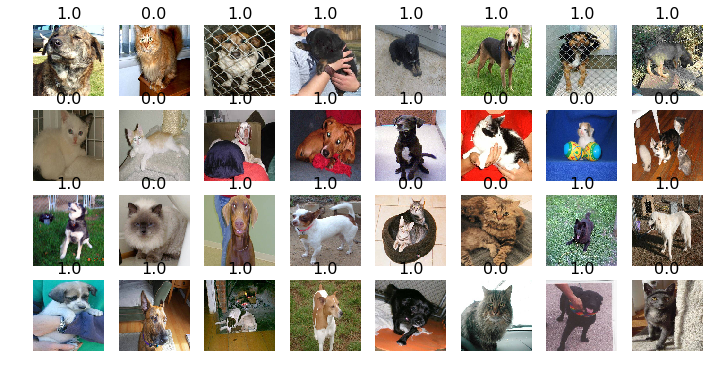

In [9]:
plots(imgs, titles = labels)

as we see we have the first batch images with their correspoding labels, [1.0] for dogs and [0.1] for cats

### Convnet Model
we are going to create a convlutional neural network model from scratch
we need to import
- Sequential: allow us to build linear stack of layers so we treat each layer as an object
- Convolution2D: it's always the first layer in cnn, it's 2d cause it deals with images
- MaxPooling2D: to reduce the dimensionality of each feature map with retaining the most important information, this reduces the computaional complexity of the network. we are going to use Max
- Activation: to be able to use whichever activation function needed
- Dropout: drops out a random set of activations in specific layer by setting them to zero as data flows through it.
- Flatten: takes output from previous layer and flatten it in 1D tensor
- Dense: to define number of nodes we want in this layer

In [62]:
from keras.layers.convolutional import *
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

we are going to build a classical Convolution network which has three Blocks followed by a fully connected layer, so the three blocks layers' architecture looks like:
* Convolution2D: first layer is always convolutional layer, 
* Activation 'relu' activation function to replace any negative values with zero.
* Maxpooling to rescale the data in smaller dimension.   
---
1. The first block learns to detect a low level feature, like curves or lines.  
the output feature map is fed into the next convolution layer 
2. In the second block the filter in this layer will learn to detect more abstract features like paws and doge 
3. The third block will learn the most complicated features in the images.
4. Flatten layer to prepare the data to dropout, we first flatten the feature map into one dimension  5. Dropout layer is a technique we use to prevent overfitting.
6. Dense,  we will want to initialize a fully connected layer with the dense function and apply 'relu' to it 
7. after the Dropout we'll initialize one more fully connected layer, this will output an N diminsional vector, which will be 2(number of classes 'dog and cat')
8. we'll apply sigmoid activation function to convert the data into probabilities for each class 

In [63]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(img_width, img_height,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
con

Now that we have completed building our CNN model, it’s time to compile it.   
We can figure the learning process by using the compile method where we'll define 
- **rmsprop** as optimization function for gradient descent
- **loss** as 'binary_crossentropy' which is the prefered loss for binary classification problems.
- **metrics** 'accuracy' since this is a classification problem.

In [64]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


## ModelTraining   
first we will define the number of training and validation data, also the number of epochs  to run for each.   
then write out our fit function to train the model giving it those parameters for training and validation data as well as the number of epochs.   

In [65]:
nb_epoch = 10
nb_train_samples = 4000
nb_validation_samples = 1000

In [16]:
model.fit_generator(
        train_generator,
        samples_per_epoch=nb_train_samples,
        nb_epoch=nb_epoch,
        validation_data=valid_generator,
        nb_val_samples=nb_validation_samples)

C:\ProgramData\Anaconda3\lib\site-packages\keras\legacy\interfaces.py:86: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., steps_per_epoch=125, epochs=10, validation_steps=1000)`
  '` call to the Keras 2 API: ' + signature)


Epoch 1/10
125/125 [==============================] - 816s - loss: 0.7306 - acc: 0.5353 - val_loss: 0.6571 - val_acc: 0.6021
Epoch 2/10
125/125 [==============================] - 802s - loss: 0.6515 - acc: 0.6515 - val_loss: 0.6021 - val_acc: 0.6909
Epoch 3/10
125/125 [==============================] - 789s - loss: 0.5867 - acc: 0.6933 - val_loss: 0.5741 - val_acc: 0.7050
Epoch 4/10
125/125 [==============================] - 781s - loss: 0.5369 - acc: 0.7338 - val_loss: 0.5788 - val_acc: 0.7190
Epoch 5/10
125/125 [==============================] - 777s - loss: 0.4847 - acc: 0.7695 - val_loss: 0.5531 - val_acc: 0.7341
Epoch 6/10
125/125 [==============================] - 767s - loss: 0.4265 - acc: 0.8080 - val_loss: 0.5506 - val_acc: 0.7492
Epoch 7/10
125/125 [==============================] - 767s - loss: 0.3817 - acc: 0.8315 - val_loss: 0.6184 - val_acc: 0.7469
Epoch 8/10
125/125 [==============================] - 768s - loss: 0.3421 - acc: 0.8525 - val_loss: 0.6270 - val_acc: 0.7360


18 epochs is better than 10, so we'll load it's weight

In [19]:
#saving weights 
model.save_weights('models/last_basic_cnn_10_epochs_2.h5')

In [66]:
#Loading pre-trained model
model.load_weights('models/last_basic_cnn_18_epochs_2.h5')

In [18]:
model.evaluate_generator(valid_generator,  nb_validation_samples)

[0.7128247434117466, 0.747136549866349]

the evaluation is not doing that good,   
so we will try to augment the data to give us better prediction   
the accuracy is just 75%, we need to find better accuracy   

## Prediction   
lets try our model and predict some images 

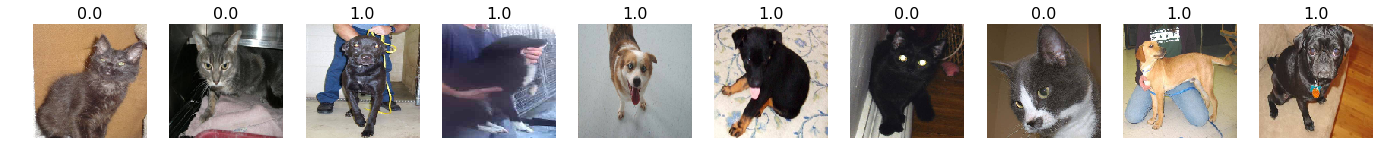

In [73]:
test_imgs, test_labels = next(test_generator)
plots(test_imgs,figsize=(24,12), rows=1 ,titles=test_labels)

In [74]:
prediction = model.predict_generator(test_generator, steps = 1)

In [75]:
prediction

array([[1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.]], dtype=float32)

The prediction looks like all of them are dogs or all cats, which is not right,    
but it's normal as the accuracy is just .75   
we need to find better way to improve the model

## Data augmentation for improving the model
By applying random transformation to our train set, we artificially enhance our dataset with new unseen images.   
This will hopefully reduce overfitting and allows better generalization capability for our network.

In [76]:
train_datagen_augmented = ImageDataGenerator(
        rotation_range=10, #rotate the image
        width_shift_range=0.1, #shift the image horisontaly
        height_shift_range=0.1, #shift the image vertically
        channel_shift_range=0.1, #shift the image
        rescale=1./255,        # normalize pixel values to [0,1]
        shear_range=0.15,       # randomly applies shearing transformation
        zoom_range=0.1,        # randomly applies shearing transformation
        horizontal_flip=True)  # randomly flip the images

# same code as before
train_generator_augmented = train_datagen_augmented.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

Found 4000 images belonging to 2 classes.


In [26]:
model.fit_generator(
        train_generator_augmented,
        samples_per_epoch=nb_train_samples,
        nb_epoch=nb_epoch,
        validation_data=valid_generator,
        nb_val_samples=nb_validation_samples)

C:\ProgramData\Anaconda3\lib\site-packages\keras\legacy\interfaces.py:86: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., steps_per_epoch=125, epochs=18, validation_steps=1000)`
  '` call to the Keras 2 API: ' + signature)


Epoch 1/18
125/125 [==============================] - 792s - loss: 0.6274 - acc: 0.6733 - val_loss: 0.5429 - val_acc: 0.7330
Epoch 2/18
125/125 [==============================] - 798s - loss: 0.5877 - acc: 0.7095 - val_loss: 0.5443 - val_acc: 0.7232
Epoch 3/18
125/125 [==============================] - 818s - loss: 0.5575 - acc: 0.7290 - val_loss: 0.4840 - val_acc: 0.7801
Epoch 4/18
125/125 [==============================] - 793s - loss: 0.5512 - acc: 0.7275 - val_loss: 0.5060 - val_acc: 0.7710
Epoch 5/18
125/125 [==============================] - 794s - loss: 0.5417 - acc: 0.7340 - val_loss: 0.4908 - val_acc: 0.7850
Epoch 6/18
125/125 [==============================] - 803s - loss: 0.5298 - acc: 0.7438 - val_loss: 0.4832 - val_acc: 0.7969
Epoch 7/18
125/125 [==============================] - 852s - loss: 0.5243 - acc: 0.7535 - val_loss: 0.4496 - val_acc: 0.8087
Epoch 8/18
125/125 [==============================] - 969s - loss: 0.5161 - acc: 0.7468 - val_loss: 0.4755 - val_acc: 0.7880


In [29]:
model.save_weights('models/last_augmented_30_epochs.h5')

In [77]:
model.load_weights('models/last_augmented_30_epochs.h5')

In [28]:
model.evaluate_generator(valid_generator, nb_validation_samples)

[0.4366777408040603, 0.8072589938870436]

the augmentation achives higher accuracy of 80%

lets see how the augmentation of data looks like!

In [40]:
image_path='data\\/validation/cats/cat.4003.jpg'

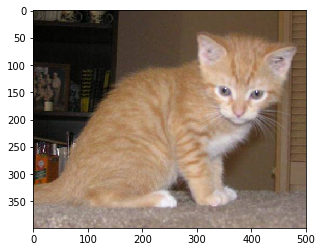

In [41]:
#from scipy import ndimage
#obtain image 
image = np.expand_dims(plt.imread(image_path),0)  #ndimage
plt.imshow(image[0])

In [55]:
aug_iter = train_datagen_augmented.flow(image)

In [56]:
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

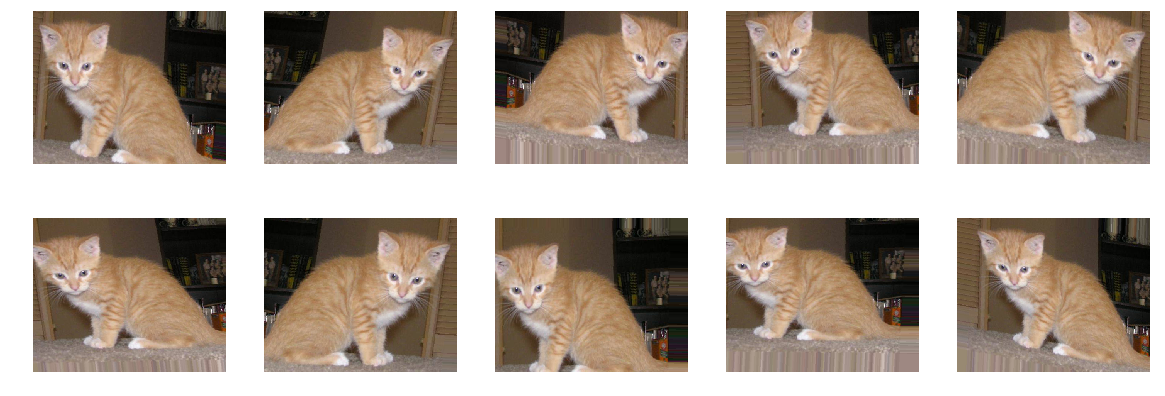

In [57]:
plots(aug_images, figsize=(20, 7), rows = 2)

Now lets evaluate the model after Augmentation

By Data Augmentation the accuracy has been imporoved to 80%  
but we still need more accuracy, so we are going to fine tuning 

lets predict some images after augmentation

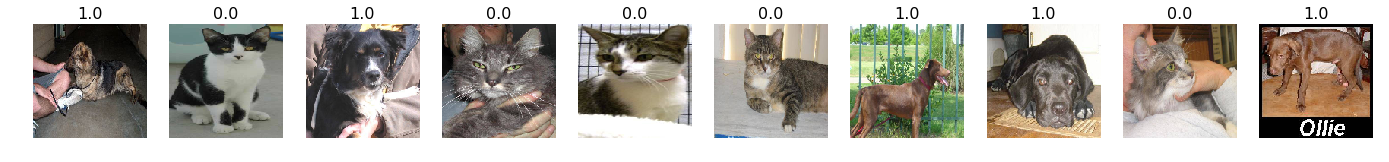

In [78]:
test_imgs, test_labels = next(test_generator)
plots(test_imgs,figsize=(24,12), rows=1 ,titles=test_labels)

In [79]:
prediction = model.predict_generator(test_generator, steps = 1)

In [80]:
prediction 

array([[1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

# Fine Tuning    
#### we are going to use VGG16 modeling to improve the performance of our model
first : Build Fine-tuned VGG16 model


In [83]:
vgg16_model = keras.applications.vgg16.VGG16()

In [84]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

as we see the VGG16 model is more complicated than our trained network, it seems that it will do better work   
but it has Dense layer at the end of 1000 class corresponding to 1000 category, but in our case we need just 2 classes, so will modify in this model

In [85]:
type(vgg16_model)

keras.engine.training.Model

as we see VGG16 of type model, but we deal with sequential, so we are going to build sequential model with the same layers of VGG16

In [86]:
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

In [87]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [88]:
#pop the last dense layer 
model.layers.pop()

In [89]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

here we prevent training to the layers of VGG16 cause it's already had a lot of training

In [90]:
for layer in model.layers:
    layer.trainable = False

now we are adding the suitable Dense layer with 2 classes, Dog and Cat

In [91]:
model.add(Dense(2, activation='softmax'))

In [92]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Now, while we have the suitable tuned model, let's compile it

In [114]:
#reprocess the images to fit the tuning 
img_width, img_height = 224, 224
train_batches = ImageDataGenerator().flow_from_directory(train_data_dir, target_size=(img_width, img_height),  batch_size=32 ,classes=['dogs','cats'])
valid_batches = ImageDataGenerator().flow_from_directory(validation_data_dir, target_size=(img_width, img_height),  batch_size=40 ,classes=['dogs','cats'])
test_batches = ImageDataGenerator().flow_from_directory(test_data_dir, target_size=(img_width, img_height), batch_size=10, classes=['dog','cat'])

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [115]:
from keras import optimizers
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
model.compile(Adam(lr=.0001), loss ='categorical_crossentropy', metrics=['accuracy'])

In [116]:
nb_train_samples = 4000 
nb_validation_samples = 1000 

In [126]:
model.fit_generator( 
        train_batches,   
        steps_per_epoch=125,
        validation_data=valid_batches,
        validation_steps=25,
        epochs=5
    )

Epoch 1/5
125/125 [==============================] - 2264s - loss: 0.6158 - acc: 0.9675 - val_loss: 0.6087 - val_acc: 0.9650
Epoch 2/5
125/125 [==============================] - 2246s - loss: 0.6005 - acc: 0.9765 - val_loss: 0.5959 - val_acc: 0.9690
Epoch 3/5
125/125 [==============================] - 2246s - loss: 0.5876 - acc: 0.9825 - val_loss: 0.5840 - val_acc: 0.9740
Epoch 4/5
125/125 [==============================] - 2257s - loss: 0.5754 - acc: 0.9870 - val_loss: 0.5728 - val_acc: 0.9740
Epoch 5/5
125/125 [==============================] - 2234s - loss: 0.5639 - acc: 0.9892 - val_loss: 0.5621 - val_acc: 0.9740


In [127]:
model.save_weights('models/final_5_epochs.h5')

In [169]:
model.load_weights('models/final_5_epochs.h5')

In [168]:
model.evaluate_generator(valid_batches,  nb_validation_samples)

[val_loss: 0.5621431408040603 - val_acc: 0.9740584736670436]


now we have reached accuracy of 97% on validation datasets in 5 epochs,   
we can do more epochs to reach 1% 